In this code is it possible to test the capability of a linear and a non-linear model to predict a oscillating that changes its magnitude in time. This is toy experiment to check the robustness of the model where there is a clear seasonality and trend in data. 

The real data generating function is dependent only on the total time since the beginning of the process (for the trend) and on the period. To simulate a real forecasting experience the model will use also the lagged values of the series. You can choose if also the time should be added. 

Results (test accuracy): 
Growing+linear+time = 0.8886    (Usa solo i lag passati, non le info sul tempo)

Growing+linear= 0.4181   (Usa in modo più efficient i lag passati)

Growing+nonlinear+time= 526.1019    (Usa tutte le info, ma dà più peso al tempo piuttosto che ai lag)

Growing+nonlinear=1.2627       (Without the time info it behaves much more as the linear models)

Shrinking+linear+time = 0.002631 (The wieghts are similar than the one with growing data, but in this case the time has more impact due to the smaller magnitude in the test set of the inputa data)

Shrinking+linear=0.001217   (In this case it uses all the lags, but the more distant ones have greater impact for their magnitude)

Shrinking+nonlinear+time=0.000320   (it mainly uses the time informations)

Shrinking+nonlinear= 0.000504 (It uses mainly the most distants lags)



In [2]:
#Selct if you want to use a linear or a non-linear model and if the amplitude of the data is growing or shrinking in time. Select if you want to use the 
#time (total time and period time) as a feature or not.

linear = True
growing = True
time = False


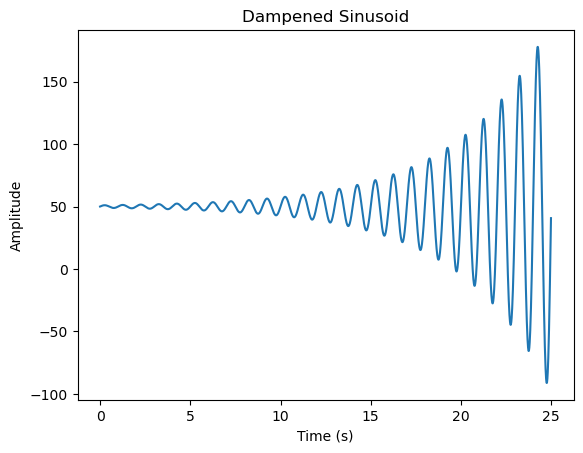

2500

In [3]:
#Simulate and plot a dampened sinusoid in time

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import math

# Define constants
if growing:
    A = 1
    b = 0.2
else:
    A = 130
    b = -0.2

f = 1
phi = 0
w = 2*math.pi*f
T = 1/f
dt = T/100
t = np.arange(0, 25*T, dt)
y = A*np.exp(b*t)*np.sin(w*t + phi)+50




# Plot the function
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Dampened Sinusoid')
plt.show()

len(y)



In [4]:
#Define a neural network class that takes the past 200 time steps as input and outputs the next 50 time steps. Use pytorch.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self): #Define the layers
        super(Net, self).__init__()
        self.relu=nn.ReLU()
        if time:            
            self.fc1 = nn.Linear(300, 100)
            self.fc2 = nn.Linear(100, 100)
            self.fc3 = nn.Linear(100, 50)
        else:         
            self.fc1 = nn.Linear(200, 100)
            self.fc2 = nn.Linear(100, 100)
            self.fc3 = nn.Linear(100, 50)
    
    def encoder(self, x):
        if linear:           
            x=self.fc1(x)
            x=self.fc2(x)
        else:
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            x = self.relu(x)
        return x
        

    def forward(self, x): #Define the forward pass        
        x=self.encoder(x)
        x = self.fc3(x)
        return x
    

In [5]:


#Divide the data into training and testing sets. The first 1500 time steps of y will be used for training and the last 1000 for testing.

y_train = y[0:1500]
y_test = y[1500:2500]

#Define the model, loss function, and optimizer and train it for 100 epochs.

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0, 1300, 50):
        # get the inputs; data is a list of [inputs, labels]
        inputs=y_train[i:i+200]
        if time:
            inputs=np.append(y_train[i:i+200], t[i+200:i+250])
            inputs=np.append(inputs, t[i+200:i+250]%1)
        inputs = torch.tensor(inputs)
        labels = torch.tensor(y_train[i+200:i+250])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.10f' %
            (epoch + 1, running_loss / 26))
    running_loss = 0.0

print('Finished Training')

[1] loss: 502.0300099300
[2] loss: 35.8841459201
[3] loss: 11.3681191252
[4] loss: 4.5468998867
[5] loss: 1.6351780368
[6] loss: 0.5124865847
[7] loss: 0.1406130821
[8] loss: 0.0350268851
[9] loss: 0.0083371440
[10] loss: 0.0019223225
[11] loss: 0.0004214606
[12] loss: 0.0000873355
[13] loss: 0.0000174464
[14] loss: 0.0000037030
[15] loss: 0.0000011156
[16] loss: 0.0000006404
[17] loss: 0.0000005435
[18] loss: 0.0000005087
[19] loss: 0.0000004689
[20] loss: 0.0000004137
[21] loss: 0.0000003433
[22] loss: 0.0000002624
[23] loss: 0.0000001865
[24] loss: 0.0000001216
[25] loss: 0.0000000710
[26] loss: 0.0000000316
[27] loss: 0.0000000102
[28] loss: 0.0000000024
[29] loss: 0.0000000008
[30] loss: 0.0000000003
[31] loss: 0.0000000002
[32] loss: 0.0000000002
[33] loss: 0.0000000002
[34] loss: 0.0000000001
[35] loss: 0.0000000001
[36] loss: 0.0000000001
[37] loss: 0.0000000001
[38] loss: 0.0000000001
[39] loss: 0.0000000001
[40] loss: 0.0000000001
[41] loss: 0.0000000001
[42] loss: 0.00000000

In [6]:
#Test the model on the entire data set and plot the results.

y_pred = []
for i in range(0, 2300, 50):
    inputs=y[i:i+200]
    if time:
        inputs=np.append(y[i:i+200], t[i+200:i+250])
        inputs=np.append(inputs, t[i+200:i+250]%1)
    inputs = torch.tensor(inputs)
    outputs = net(inputs.float())
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(2300)

#plot with plotly with a line where the training set ends

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:2500], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:2500], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[1500], t[1500]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()



In [7]:
#Visualize the input and latent space principal components

#Compute and plot the input space and the output space principal components

from sklearn.decomposition import PCA

output = []
input = []
preds_space=[]
for i in range(0, 2300, 50):
    inputs=y[i:i+200]
    if time:
        inputs=np.append(y[i:i+200], t[i+200:i+250])
        inputs=np.append(inputs, t[i+200:i+250]%1)
    inputs = torch.tensor(inputs)
    outputs =net.encoder(inputs.float())
    preds=net.fc3(outputs)
    output.append(outputs.detach().numpy())
    input.append(inputs.detach().numpy())
    preds_space.append(preds.detach().numpy())

input=np.array(input)
output=np.array(output)
preds_space=np.array(preds_space)

pca = PCA(n_components=2)
pca.fit(input)
input_pca = pca.transform(input)

pca = PCA(n_components=2)
pca.fit(output)
output_pca = pca.transform(output)

pca = PCA(n_components=2)
pca.fit(preds_space)
preds_pca = pca.transform(preds_space)


#plot with plotly in two separate plots

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=input_pca[:,0], y=input_pca[:,1], mode='markers', name='Input Space'))
fig.update_layout(title='Input Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=output_pca[:,0], y=output_pca[:,1], mode='markers', name='Output Space'))
fig.update_layout(title='Output Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=preds_pca[:,0], y=preds_pca[:,1], mode='markers', name='preds Space'))
fig.update_layout(title='Latent Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()






In [8]:
#Visualize the input and latent space principal components after shiftin the input

#Compute and plot the input space and the output space principal components

from sklearn.decomposition import PCA

output = []
input = []
preds_space=[]
for i in range(0, 2300, 50):
    inputs=1000+y[i:i+200]
    if time:
        inputs=np.append(y[i:i+200], t[i+200:i+250])
        inputs=np.append(inputs, t[i+200:i+250]%1)
    inputs = torch.tensor(inputs)
    outputs =net.encoder(inputs.float())
    preds=net.fc3(outputs)
    output.append(outputs.detach().numpy())
    input.append(inputs.detach().numpy())
    preds_space.append(preds.detach().numpy())

input=np.array(input)
output=np.array(output)
preds_space=np.array(preds_space)

pca = PCA(n_components=2)
pca.fit(input)
input_pca = pca.transform(input)

pca = PCA(n_components=2)
pca.fit(output)
output_pca = pca.transform(output)

pca = PCA(n_components=2)
pca.fit(preds_space)
preds_pca = pca.transform(preds_space)


#plot with plotly in two separate plots

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=input_pca[:,0], y=input_pca[:,1], mode='markers', name='Input Space'))
fig.update_layout(title='Input Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=output_pca[:,0], y=output_pca[:,1], mode='markers', name='Output Space'))
fig.update_layout(title='Output Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=preds_pca[:,0], y=preds_pca[:,1], mode='markers', name='preds Space'))
fig.update_layout(title='Latent Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()

In [9]:
#Visualize which areas of the mean-variance space are learned by the encoder

import torch
import torch.nn as nn
import numpy as np
import plotly.graph_objects as go

# Input generation
num_samples = 200
input_dim = 200

# Generate some 200-dimensional inputs with random means and variances
inputs = np.array([np.random.normal(1000*(np.random.rand()-0.5), 100*np.random.rand(), input_dim) for _ in range(num_samples)])

# Compute input means and variances
input_means = np.mean(inputs, axis=1)
input_vars = np.std(inputs, axis=1)

# Transfer inputs to tensors
inputs_tensor = torch.from_numpy(inputs.astype(np.float32))

# Apply encoder
encoded = net.encoder(inputs_tensor).detach().numpy()

# Compute means and variances of the encoded data
encoded_means = np.mean(encoded, axis=1)
encoded_vars = np.std(encoded, axis=1)

# Create a scatter plot for the original and encoded data
fig = go.Figure()

# Original data
fig.add_trace(go.Scatter(
    x=input_means, y=input_vars,
    mode='markers',
    name='Original',
    marker=dict(
        size=8,
        color='blue',
        opacity=0.5,
    )
))

# Encoded data
fig.add_trace(go.Scatter(
    x=encoded_means, y=encoded_vars,
    mode='markers',
    name='Encoded',
    marker=dict(
        size=8,
        color='red',
        opacity=0.5,
    )
))

# Add lines connecting original and encoded points
for (x1, y1), (x2, y2) in zip(zip(input_means, input_vars), zip(encoded_means, encoded_vars)):
    fig.add_trace(go.Scatter(
        x=[x1, x2], y=[y1, y2],
        mode='lines',
        line=dict(color='green', width=0.5),
        showlegend=False,
    ))



fig.update_layout(
    title='Mean and Standard Deviation before and after encoding',
    xaxis_title='Mean',
    yaxis_title='Standard Deviation',
    legend=dict(
        y=0.2,
        traceorder='reversed',
        font=dict(
            size=16,
        )
    )
)

fig.show()


In [12]:
#In this section we take the inputs from the training set and verify how much the loss deteriorates when we shift and rescale the input
import plotly.graph_objects as go


#shift and rescale the input
means=[]
stds=[]
losses=[]
fig = go.Figure()
for mean in range(-250, 250, 50):
    for std in range(1, 100, 5):
        y_pred = []
        scaled_inputs=((y_train-np.mean(y_train))/np.std(y_train))*std+mean
        temp_loss=[]
        for i in range(0, 1300, 50):
            # get the inputs; data is a list of [inputs, labels]
            inputs = torch.tensor(scaled_inputs[i:i+200]).float()
            labels = torch.tensor(scaled_inputs[i+200:i+250]).float()
            preds =net(inputs)
            y_pred.append(preds.detach().numpy())
            temp_loss.append(((preds - labels.float()).abs() / (labels.float()[:-1]-labels.float()[1:]).abs().mean()).mean().detach().numpy())
        losses.append(np.mean(temp_loss))
        means.append(mean)
        stds.append(std)      

#plot the loss as a function of the parameters of the affine function

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=means, y=stds, z=losses, mode='markers', name='Loss'))
for i in range(len(losses)):
    if losses[i]<=1:
        fig.add_trace(go.Scatter3d(x=[means[i]], y=[stds[i]], z=[losses[i]], mode='markers', name='Stable region', marker=dict(color='green')))
fig.update_layout(title='Mean Absolute Scaled Error as a function of the mean and the standard deviation', scene = dict(xaxis_title='Mean', yaxis_title='Std',zaxis_title='MASE'))
fig.show()



In [11]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.interpolate import griddata

x = np.array(means)
y = np.array(stds)
z = np.array(losses)


xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)

X,Y = np.meshgrid(xi,yi)

Z = griddata((x,y),z,(X,Y), method='cubic')


#Change the color scale to be green when the loss is less than 1
fig = go.Figure(go.Surface(x=xi,y=yi,z=Z))

fig.update_layout(title='Mean Absolute Scaled Error as a function of the mean and the standard deviation', scene = dict(xaxis_title='Mean', yaxis_title='Std',zaxis_title='MASE'), 
            )

fig.show()